In [5]:
import pandas as pd
import numpy as np
from astropy.coordinates import SkyCoord, Galactocentric
from astropy import units as u
import matplotlib.pyplot as plt
import seaborn as sns

# Load the downloaded data
gaia_df = pd.read_csv("Q2.csv")

# Basic data inspection
print(f"Initial dataset size: {len(gaia_df)}")
print("Available columns:\n", gaia_df.columns.tolist())

# Essential columns check
essential_cols = ['ra', 'dec', 'parallax', 'pmra', 'pmdec', 'phot_g_mean_mag', 'bp_rp']
missing_cols = [col for col in essential_cols if col not in gaia_df.columns]
if missing_cols:
    raise ValueError(f"Missing essential columns: {missing_cols}")

# Basic cleaning
gaia_df = gaia_df.dropna(subset=essential_cols)
gaia_df = gaia_df[gaia_df['parallax'] > 0]  # Positive parallax only
print(f"After basic cleaning: {len(gaia_df)}")

Initial dataset size: 100000
Available columns:
 ['source_id', 'ra', 'dec', 'parallax', 'parallax_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'radial_velocity', 'radial_velocity_error', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'bp_rp', 'phot_g_mean_flux', 'phot_g_mean_flux_error', 'phot_bp_mean_flux', 'phot_bp_mean_flux_error', 'phot_rp_mean_flux', 'phot_rp_mean_flux_error', 'ruwe', 'astrometric_excess_noise', 'teff_gspphot', 'logg_gspphot', 'mh_gspphot', 'ag_gspphot', 'ebpminrp_gspphot', 'phot_variable_flag', 'non_single_star', 'has_epoch_photometry', 'has_epoch_rv', 'has_xp_continuous', 'has_xp_sampled', 'has_rvs']
After basic cleaning: 100000


Initial dataset size: 100000
After cleaning: 100000
Full 6D transformation completed


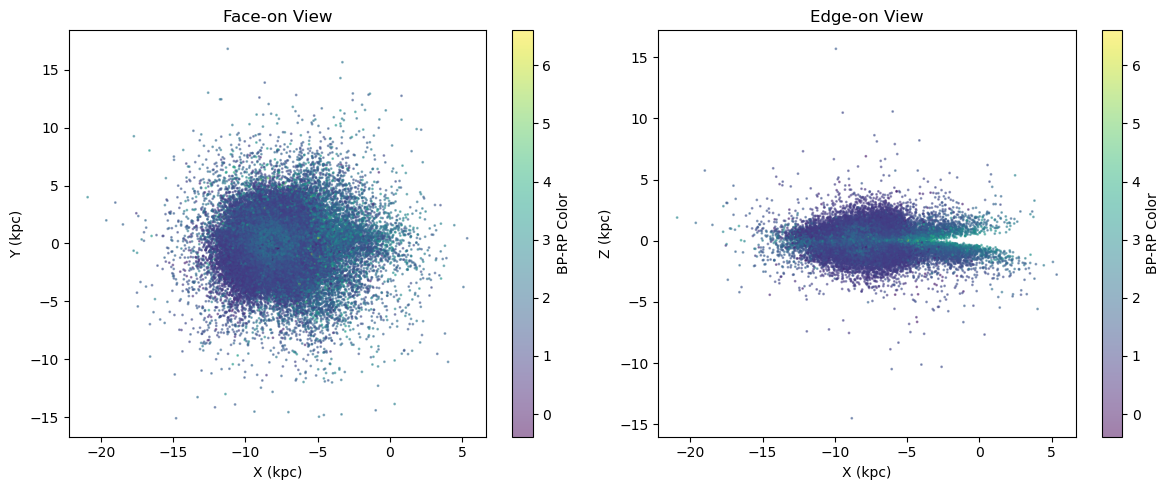

Processing complete! Data saved to Q2_processed.csv


In [8]:
import pandas as pd
import numpy as np
from astropy.coordinates import SkyCoord, Galactocentric
from astropy import units as u
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load and clean data
gaia_df = pd.read_csv("Q2.csv")
print(f"Initial dataset size: {len(gaia_df)}")

# Keep only essential columns that exist
essential_cols = ['ra', 'dec', 'parallax', 'phot_g_mean_mag', 'bp_rp']
available_cols = [col for col in essential_cols if col in gaia_df.columns]
gaia_df = gaia_df.dropna(subset=available_cols)
gaia_df = gaia_df[gaia_df['parallax'] > 0]
print(f"After cleaning: {len(gaia_df)}")

# 2. Distance calculation
gaia_df['distance_pc'] = 1000 / gaia_df['parallax']

# 3. Coordinate transformation with fallback
try:
    # Create coordinate object with available data
    coord_kwargs = {
        'ra': gaia_df['ra'].values * u.deg,
        'dec': gaia_df['dec'].values * u.deg,
        'distance': gaia_df['distance_pc'].values * u.pc,
        'frame': 'icrs'
    }
    
    # Add proper motions if available
    if 'pmra' in gaia_df.columns and 'pmdec' in gaia_df.columns:
        coord_kwargs['pm_ra_cosdec'] = gaia_df['pmra'].values * u.mas/u.yr
        coord_kwargs['pm_dec'] = gaia_df['pmdec'].values * u.mas/u.yr
    
    # Add radial velocity if available
    if 'radial_velocity' in gaia_df.columns:
        coord_kwargs['radial_velocity'] = gaia_df['radial_velocity'].values * u.km/u.s
    
    coords_icrs = SkyCoord(**coord_kwargs)
    
    # Try transformation (with or without velocities)
    if 'pm_ra_cosdec' in coord_kwargs and 'pm_dec' in coord_kwargs and 'radial_velocity' in coord_kwargs:
        coords_galcen = coords_icrs.transform_to(Galactocentric())
        print("Full 6D transformation completed")
    else:
        coords_galcen = coords_icrs.transform_to(Galactocentric(galcen_v_sun=None))
        print("3D position-only transformation completed")
    
    # Store results
    gaia_df['x_galcen_kpc'] = coords_galcen.x.to(u.kpc).value
    gaia_df['y_galcen_kpc'] = coords_galcen.y.to(u.kpc).value
    gaia_df['z_galcen_kpc'] = coords_galcen.z.to(u.kpc).value
    
except Exception as e:
    print(f"Astropy transformation failed: {e}")
    print("Using simple cartesian projection instead")
    gaia_df['x_galcen_kpc'] = -gaia_df['distance_pc'] * np.cos(np.radians(gaia_df['dec'])) * np.cos(np.radians(gaia_df['ra'])) / 1000
    gaia_df['y_galcen_kpc'] = gaia_df['distance_pc'] * np.cos(np.radians(gaia_df['dec'])) * np.sin(np.radians(gaia_df['ra'])) / 1000
    gaia_df['z_galcen_kpc'] = gaia_df['distance_pc'] * np.sin(np.radians(gaia_df['dec'])) / 1000

# 4. Basic visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(gaia_df['x_galcen_kpc'], gaia_df['y_galcen_kpc'], 
            c=gaia_df['bp_rp'], cmap='viridis', s=1, alpha=0.5)
plt.colorbar(label='BP-RP Color')
plt.xlabel('X (kpc)')
plt.ylabel('Y (kpc)')
plt.title('Face-on View')

plt.subplot(1, 2, 2)
plt.scatter(gaia_df['x_galcen_kpc'], gaia_df['z_galcen_kpc'], 
            c=gaia_df['bp_rp'], cmap='viridis', s=1, alpha=0.5)
plt.colorbar(label='BP-RP Color')
plt.xlabel('X (kpc)')
plt.ylabel('Z (kpc)')
plt.title('Edge-on View')

plt.tight_layout()
plt.savefig('gaia_views.png', dpi=300)
plt.show()

# 5. Save processed data
gaia_df.to_csv('Q2_processed.csv', index=False)
print("Processing complete! Data saved to Q2_processed.csv")

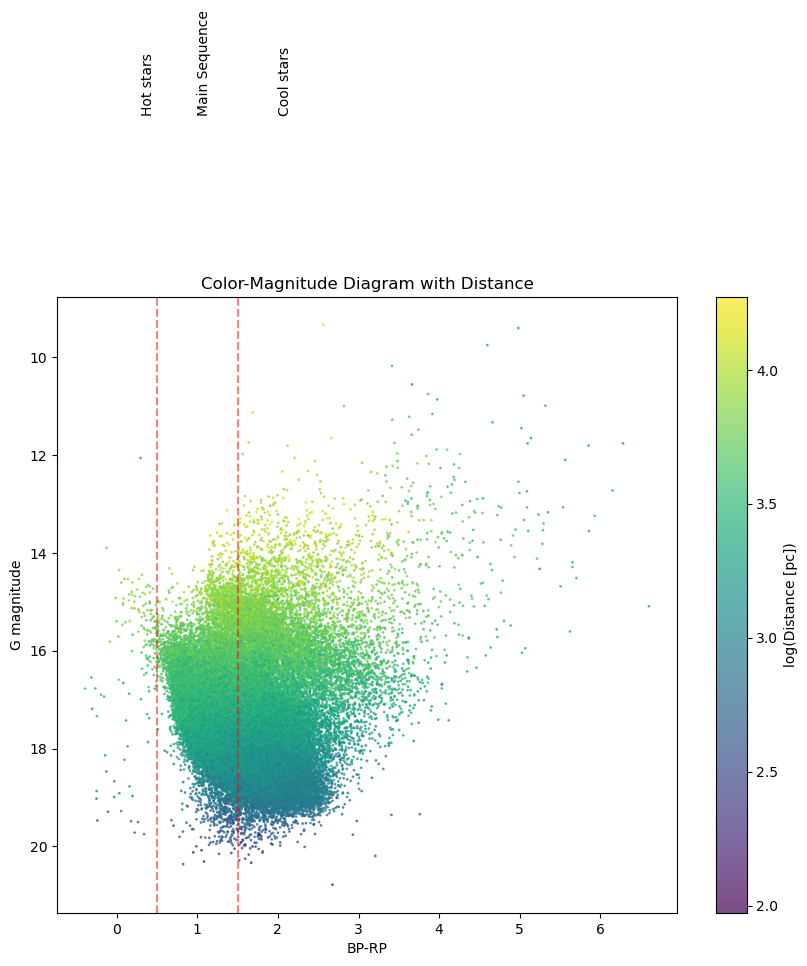

In [9]:
# CMD-based population classification
plt.figure(figsize=(10, 8))
plt.scatter(gaia_df['bp_rp'], gaia_df['phot_g_mean_mag'], 
            c=np.log10(gaia_df['distance_pc']), 
            cmap='viridis', s=1, alpha=0.7)
plt.colorbar(label='log(Distance [pc])')
plt.gca().invert_yaxis()
plt.xlabel('BP-RP')
plt.ylabel('G magnitude')
plt.title('Color-Magnitude Diagram with Distance')

# Add theoretical isochrones or population boundaries
plt.axvline(0.5, color='red', linestyle='--', alpha=0.5)
plt.axvline(1.5, color='red', linestyle='--', alpha=0.5)
plt.text(0.3, 5, 'Hot stars', rotation=90)
plt.text(1.0, 5, 'Main Sequence', rotation=90)
plt.text(2.0, 5, 'Cool stars', rotation=90)
plt.savefig('stellar_populations.png', dpi=300)

In [12]:
if all(col in gaia_df.columns for col in ['vx_galcen_kms', 'vy_galcen_kms', 'vz_galcen_kms']):
    # Calculate angular momentum
    gaia_df['Lz'] = gaia_df['x_galcen_kpc'] * gaia_df['vy_galcen_kms'] - gaia_df['y_galcen_kpc'] * gaia_df['vx_galcen_kms']
    
    # Toomre diagram
    plt.figure(figsize=(10, 8))
    plt.scatter(gaia_df['vx_galcen_kms'], 
                np.sqrt(gaia_df['vy_galcen_kms']**2 + gaia_df['vz_galcen_kms']**2),
                c=gaia_df['bp_rp'], cmap='plasma', s=1, alpha=0.7)
    plt.colorbar(label='BP-RP')
    plt.xlabel('Vx [km/s] (radial)')
    plt.ylabel('√(Vy² + Vz²) [km/s]')
    plt.title('Toomre Diagram')
    plt.savefig('toomre_diagram.png', dpi=300)
    plt.show()

In [13]:
print(all(col in gaia_df.columns for col in ['vx_galcen_kms', 'vy_galcen_kms', 'vz_galcen_kms']))


False


In [14]:
for col in ['vx_galcen_kms', 'vy_galcen_kms', 'vz_galcen_kms']:
    print(col, "in DataFrame:", col in gaia_df.columns)


vx_galcen_kms in DataFrame: False
vy_galcen_kms in DataFrame: False
vz_galcen_kms in DataFrame: False


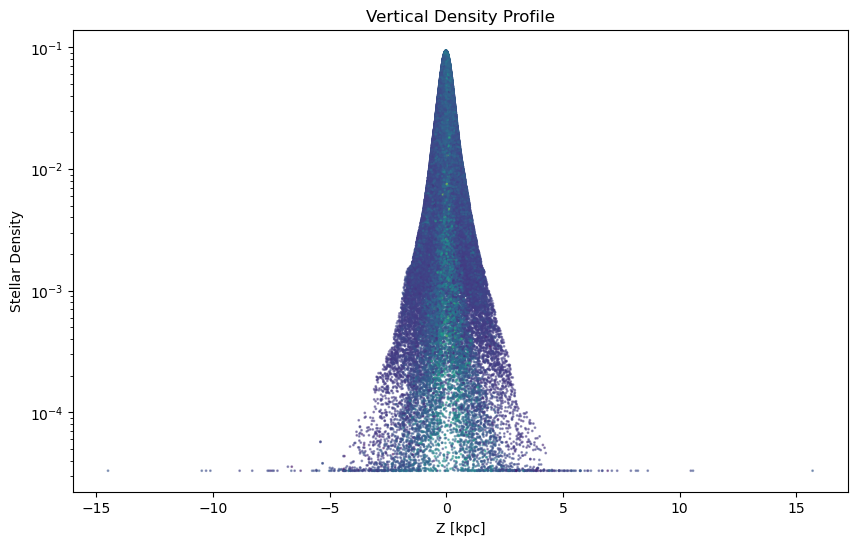

In [15]:
from scipy.stats import gaussian_kde

# 3D density estimation
xyz = gaia_df[['x_galcen_kpc', 'y_galcen_kpc', 'z_galcen_kpc']].values.T
kde = gaussian_kde(xyz)
density = kde(xyz)

# Plot density vs height
plt.figure(figsize=(10, 6))
plt.scatter(gaia_df['z_galcen_kpc'], density, 
            c=gaia_df['bp_rp'], s=1, alpha=0.5)
plt.yscale('log')
plt.xlabel('Z [kpc]')
plt.ylabel('Stellar Density')
plt.title('Vertical Density Profile')
plt.savefig('vertical_density.png', dpi=300)

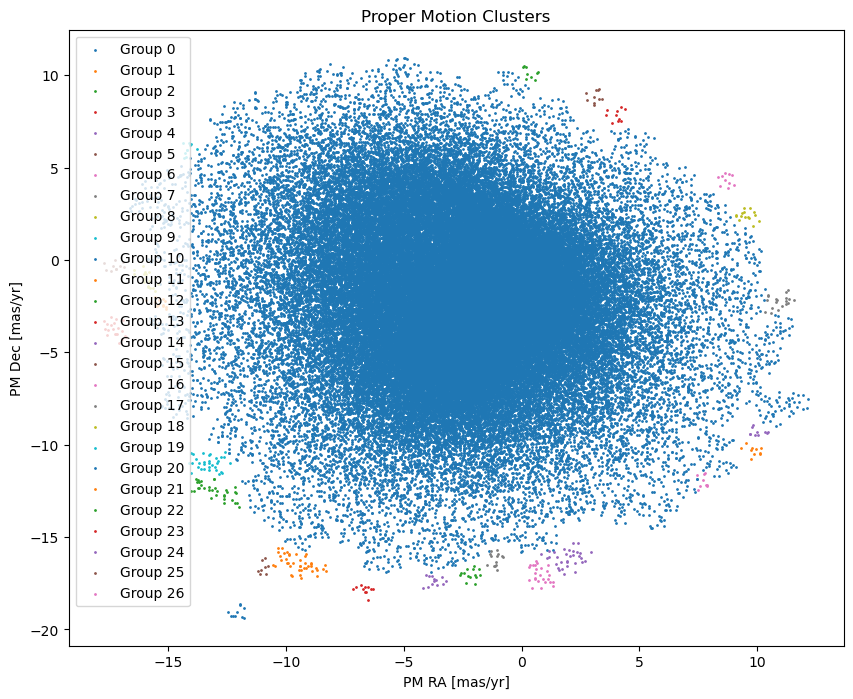

In [16]:
from sklearn.cluster import DBSCAN

if all(col in gaia_df.columns for col in ['pmra', 'pmdec']):
    # Cluster in proper motion space
    pm_data = gaia_df[['pmra', 'pmdec']].values
    pm_data = (pm_data - np.mean(pm_data, axis=0)) / np.std(pm_data, axis=0)  # Normalize
    
    clustering = DBSCAN(eps=0.1, min_samples=10).fit(pm_data)
    gaia_df['pm_group'] = clustering.labels_
    
    # Plot results
    plt.figure(figsize=(10, 8))
    for group in np.unique(clustering.labels_):
        if group != -1:  # Skip noise
            mask = clustering.labels_ == group
            plt.scatter(gaia_df.loc[mask, 'pmra'], 
                        gaia_df.loc[mask, 'pmdec'],
                        s=1, label=f'Group {group}')
    plt.xlabel('PM RA [mas/yr]')
    plt.ylabel('PM Dec [mas/yr]')
    plt.title('Proper Motion Clusters')
    plt.legend()
    plt.savefig('moving_groups.png', dpi=300)

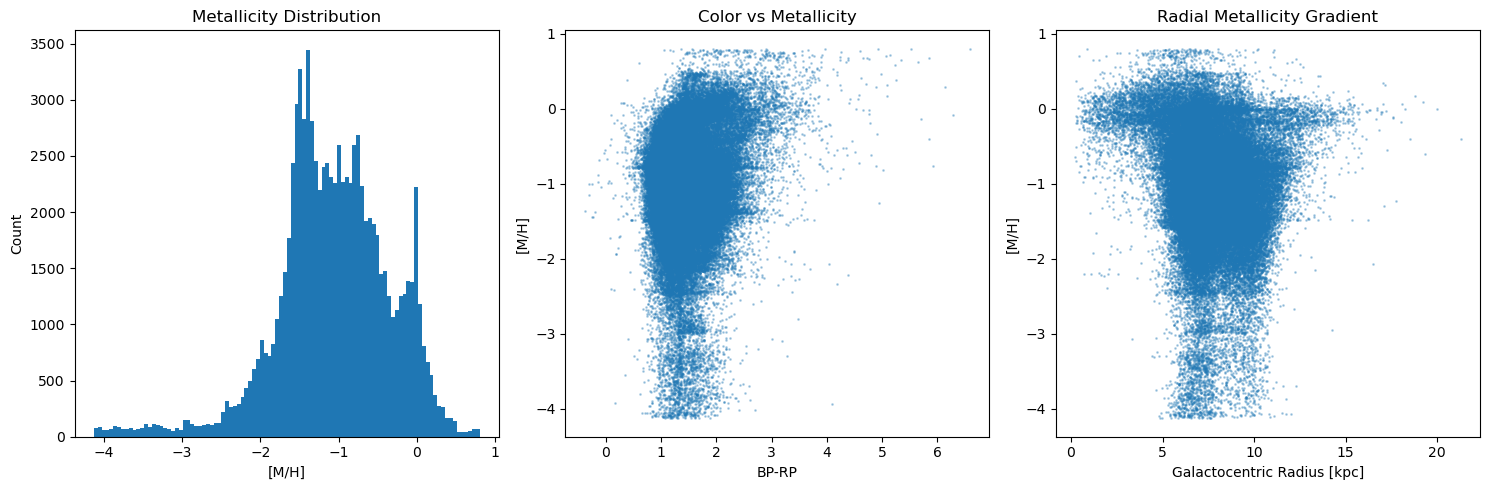

In [17]:
if 'mh_gspphot' in gaia_df.columns:
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.hist(gaia_df['mh_gspphot'].dropna(), bins=100)
    plt.xlabel('[M/H]')
    plt.ylabel('Count')
    plt.title('Metallicity Distribution')
    
    plt.subplot(1, 3, 2)
    plt.scatter(gaia_df['bp_rp'], gaia_df['mh_gspphot'], s=1, alpha=0.3)
    plt.xlabel('BP-RP')
    plt.ylabel('[M/H]')
    plt.title('Color vs Metallicity')
    
    plt.subplot(1, 3, 3)
    plt.scatter(np.sqrt(gaia_df['x_galcen_kpc']**2 + gaia_df['y_galcen_kpc']**2),
                gaia_df['mh_gspphot'], s=1, alpha=0.3)
    plt.xlabel('Galactocentric Radius [kpc]')
    plt.ylabel('[M/H]')
    plt.title('Radial Metallicity Gradient')
    
    plt.tight_layout()
    plt.savefig('metallicity_analysis.png', dpi=300)

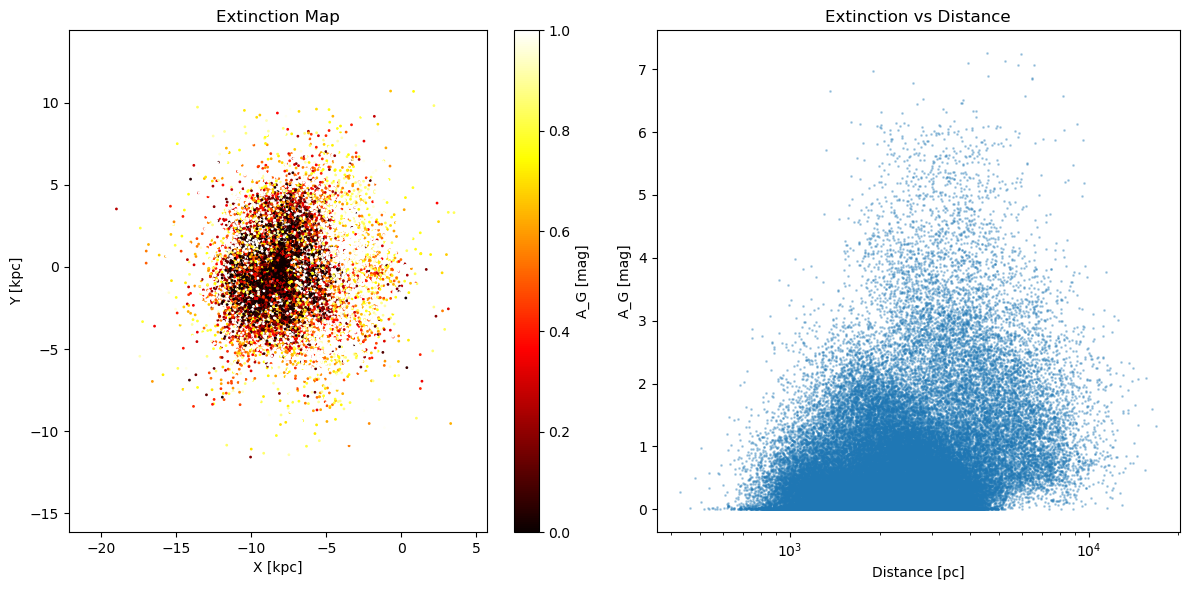

In [18]:
if 'ag_gspphot' in gaia_df.columns:
    plt.figure(figsize=(12, 6))
    
    # Spatial extinction map
    plt.subplot(1, 2, 1)
    plt.scatter(gaia_df['x_galcen_kpc'], gaia_df['y_galcen_kpc'],
                c=gaia_df['ag_gspphot'], cmap='hot', vmax=1, s=1)
    plt.colorbar(label='A_G [mag]')
    plt.xlabel('X [kpc]')
    plt.ylabel('Y [kpc]')
    plt.title('Extinction Map')
    
    # Extinction vs distance
    plt.subplot(1, 2, 2)
    plt.scatter(gaia_df['distance_pc'], gaia_df['ag_gspphot'], s=1, alpha=0.3)
    plt.xscale('log')
    plt.xlabel('Distance [pc]')
    plt.ylabel('A_G [mag]')
    plt.title('Extinction vs Distance')
    
    plt.tight_layout()
    plt.savefig('extinction_analysis.png', dpi=300)

In [19]:
if all(col in gaia_df.columns for col in ['vx_galcen_kms', 'vy_galcen_kms', 'vz_galcen_kms']):
    # Calculate orbital parameters
    gaia_df['v_circ'] = np.sqrt(gaia_df['vx_galcen_kms']**2 + gaia_df['vy_galcen_kms']**2)
    gaia_df['eccentricity'] = np.sqrt(1 + (gaia_df['v_circ']**2 * gaia_df['z_galcen_kpc']**2) / 
                             (gaia_df['distance_pc']/1000 * gaia_df['v_circ']**2))
    
    # Plot eccentricity distribution
    plt.figure(figsize=(10, 6))
    plt.hist(gaia_df['eccentricity'].dropna(), bins=100)
    plt.xlabel('Orbital Eccentricity')
    plt.ylabel('Count')
    plt.title('Eccentricity Distribution')
    plt.savefig('orbital_eccentricity.png', dpi=300)

In [24]:
import plotly.graph_objects as go


# Sample data for better performance (ensure gaia_df is defined)
# Example: gaia_df = pd.read_csv('gaia_data.csv') or similar
sample_df = gaia_df.sample(5000, random_state=42)

fig = go.Figure()

# Add star positions
fig.add_trace(go.Scatter3d(
    x=sample_df['x_galcen_kpc'],
    y=sample_df['y_galcen_kpc'],
    z=sample_df['z_galcen_kpc'],
    mode='markers',
    marker=dict(
        size=3,
        color=sample_df['bp_rp'],
        colorscale='Plasma',
        opacity=0.8
    ),
    name='Stars'
))

# Add velocity vectors if available
if all(col in sample_df.columns for col in ['vx_galcen_kms', 'vy_galcen_kms', 'vz_galcen_kms']):
    scale = 0.1  # Scaling factor for visibility
    fig.add_trace(go.Cone(
        x=sample_df['x_galcen_kpc'],
        y=sample_df['y_galcen_kpc'],
        z=sample_df['z_galcen_kpc'],
        u=sample_df['vx_galcen_kms'] * scale,
        v=sample_df['vy_galcen_kms'] * scale,
        w=sample_df['vz_galcen_kms'] * scale,
        sizemode='absolute',
        sizeref=20,
        showscale=False,
        name='Velocity'
    ))

# Animation settings
fig.update_layout(
    scene=dict(
        xaxis=dict(title='X [kpc] → GC'),
        yaxis=dict(title='Y [kpc] → Rotation'),
        zaxis=dict(title='Z [kpc] ↑ North'),
        camera=dict(eye=dict(x=1.5, y=1.5, z=0.8))
    ),
    updatemenus=[dict(
        type='buttons',
        showactive=False,
        buttons=[dict(
            label='Play',
            method='animate',
            args=[None, dict(frame=dict(duration=50, redraw=True), fromcurrent=True, mode='immediate')]
        )]
    )]
)

# Create rotation frames
frames = [go.Frame(
    layout=dict(
        scene_camera=dict(eye=dict(
            x=1.5 * np.cos(angle),
            y=1.5 * np.sin(angle),
            z=0.8))
    )
) for angle in np.linspace(0, 2 * np.pi, 36)]

fig.frames = frames
fig.write_html("galactic_rotation_3d.html")

In [34]:
from matplotlib.animation import ArtistAnimation

if all(col in gaia_df.columns for col in ['vx_galcen_kms','vy_galcen_kms']):
    # Select stars in a small spatial region
    cluster = gaia_df[
        (gaia_df['x_galcen_kpc'].between(-8.2, -7.8)) &
        (gaia_df['y_galcen_kpc'].between(0, 0.4))
    ].sample(100)

    fig, ax = plt.subplots(figsize=(10, 8))
    artists = []

    # Simulate orbital diffusion
    for t in np.linspace(0, 2*np.pi, 60):
        # Simple harmonic oscillator model
        x = cluster['x_galcen_kpc'] + 0.1*np.sin(t)
        y = cluster['vy_galcen_kms'] + 5*np.cos(t)
        
        scat = ax.scatter(x, y, c=cluster['bp_rp'], s=30, cmap='plasma')
        artists.append([scat])
        
    ax.set_xlim(-9, -7)
    ax.set_ylim(-50, 50)
    ax.set_xlabel('X Position [kpc]')
    ax.set_ylabel('Vy Velocity [km/s]')
    
    ani = ArtistAnimation(fig, artists, interval=100, blit=True)
    ani.save('phase_mixing.mp4', writer='ffmpeg')